# Modeling Of Conditional Expectation

This document explains each function in the code for option pricing simulation and modeling. The code uses stochastic processes to simulate asset prices and then prices options using both Monte Carlo simulation and the Black-Scholes formula. Below is a detailed explanation with relevant formulas in LaTeX.

---

## 1. `GeneratePaths`

### **Purpose:**
Simulate asset price paths using a **jump-diffusion process**.

### **Theory:**
In quantitative finance, asset prices are modeled by stochastic processes. While the **geometric Brownian motion** is a common choice, adding a jump component allows the model to capture sudden market movements or "jumps." This is particularly useful in real markets where unexpected events occur.

### **Method & Formulas:**
- **Log-Price Representation:**
  $$ X_t = \ln(S_t) $$
- **Stochastic Differential Equation:**
  $$ dX_t = \left(r - \frac{1}{2}J^2\right) dt + J \, dW_t $$
  where:
  - \( r \) is the risk-free rate,
  - \( J \) is the jump component drawn from a normal distribution \( \mathcal{N}(\mu_J, \sigma_J) \),
  - \( dW_t \) is the increment of a standard Brownian motion.
- **Reconstructing the Asset Price:**
  $$ S_t = e^{X_t} $$

### **Implementation:**
- Initialize matrices for the log-price \( X \) and the asset price \( S \).
- Generate random variables for the Brownian increments \( Z \) and the jump component \( J \).
- Iterate over time steps, updating \( X \) using the SDE and computing \( S \) as the exponential of \( X \).

---










In [2]:
import numpy as np
import matplotlib.pyplot as plt
import enum
import scipy.stats as stats

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

# ploting jumb deffusion
def GeneratePaths(NoOfPaths,NoOfSteps,S0,T,muJ,sigmaJ,r):    
    X=np.zeros([NoOfPaths,NoOfSteps+1])
    S=np.zeros([NoOfPaths,NoOfSteps+1])
    time=np.zeros([NoOfSteps+1])
    
    dt=T/float(NoOfSteps)
    X[:,0]=np.log(S0)
    S[:,0]=S0
    
    Z= np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    J= np.random.normal(muJ,sigmaJ,[NoOfPaths,NoOfSteps])
    for i in range(0,NoOfSteps):
        if NoOfPaths>1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        X[:,i+1]=X[:,i]+(r-0.5*J[:,i]**2.0)*dt+J[:,i]*np.sqrt(dt)* Z[:,i]
        time[i+1]=time[i]+dt
    S=np.exp(X)
    paths={"time":time,
               "X":X,
               "S":S,
               "J":J}
    return paths
    

## 2. `EUOptionPriceFromMCPaths`

### **Purpose:**
Calculate the price of a European Call or Put option using **Monte Carlo simulation**.

### **Theory:**
Monte Carlo methods are a staple in quantitative finance for estimating the expected payoff of derivatives under the risk-neutral measure. By simulating many paths for the asset price, one can approximate the expected value of the option's payoff.

### **Formulas:**
- **European Call Option:**
  $$ C = e^{-rT} \, \mathbb{E}\left[\max(S_T - K, \, 0)\right] $$
- **European Put Option:**
  $$ P = e^{-rT} \, \mathbb{E}\left[\max(K - S_T, \, 0)\right] $$
where:
- \( S_T \) is the asset price at maturity \( T \),
- \( K \) is the strike price,
- \( r \) is the risk-free rate.

### **Implementation:**
- For each simulated asset path, compute the payoff \( \max(S_T - K, \, 0) \) for a call (or \( \max(K - S_T, \, 0) \) for a put).
- Discount the average payoff to present value using \( e^{-rT} \).

---


In [3]:
def EUOptionPriceFromMCPaths(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    if CP == OptionType.CALL:
        return np.exp(-r*T)*np.mean(np.maximum(S-K,0.0))
    elif CP == OptionType.PUT:
        return np.exp(-r*T)*np.mean(np.maximum(K-S,0.0))


## 3. `BS_Call_Put_Option_Price`

### **Purpose:**
Compute the price of a European Call or Put option using the **Black-Scholes formula**.

### **Theory:**
The Black-Scholes model provides a closed-form solution for European options. Despite its assumptions (constant volatility, no dividends, etc.), it remains a cornerstone in the pricing of options and serves as a benchmark in the industry.

### **Formulas:**
- **Calculate \( d_1 \) and \( d_2 \):**
  $$ d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)(T-t)}{\sigma \sqrt{T-t}} $$
  $$ d_2 = d_1 - \sigma \sqrt{T-t} $$
- **Call Option Price:**
  $$ C = S_0 \, N(d_1) - K \, e^{-r (T-t)} \, N(d_2) $$
- **Put Option Price:**
  $$ P = K \, e^{-r (T-t)} \, N(-d_2) - S_0 \, N(-d_1) $$
where:
- \( S_0 \) is the current asset price,
- \( \sigma \) is the volatility,
- \( N(\cdot) \) denotes the cumulative distribution function of the standard normal distribution.

### **Implementation:**
- Compute \( d_1 \) and \( d_2 \) based on the input parameters.
- Apply the corresponding formula for a call or a put to return the option price.

---

In [4]:
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))
    * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    if CP == OptionType.CALL:
        value = stats.norm.cdf(d1) * S_0 - stats.norm.cdf(d2) * K * np.exp(-r * (T-t))
    elif CP == OptionType.PUT:
        value = stats.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - stats.norm.cdf(-d1)*S_0
    return value

## 4. `CallOption_CondExpectation`

### **Purpose:**
Estimate the price of a call option using **conditional expectation** based on the jump component at maturity.

### **Theory:**
Conditional expectation can reduce variance in Monte Carlo estimates by conditioning on a particular component—in this case, the jump \( J \) at time \( T \). By using the jump information in the Black-Scholes formula, the estimator can be more efficient.

### **Method:**
1. Extract the jump component \( J_i \) at maturity from each simulated path.
2. Compute the Black-Scholes call option price for each path using the specific \( J_i \) as the volatility parameter.
   $$ C_i = BS\_Call\_Put\_Option\_Price(\text{CALL}, S_0, K, J_i, 0, T, r) $$
3. Take the average:
   $$ C = \frac{1}{N} \sum_{i=1}^{N} C_i $$

---

In [5]:
def CallOption_CondExpectation(NoOfPaths,T,S0,K,J,r):
    #single value of j
    J_i=J[:,-1]
    result=np.zeros([NoOfPaths])
    for j in range(0,NoOfPaths):
        
        sigma=J_i[j]
        result[j]=BS_Call_Put_Option_Price(OptionType.CALL,S0,[K],sigma,0.0,T,r)
        
    return np.mean(result)

## 5. `mainCalculation`

### **Purpose:**
Run the entire simulation and pricing process, visualize the simulated paths, and examine the convergence behavior of the option price estimates.

### **Theory:**
The convergence of the Monte Carlo method is crucial in quant finance. By increasing the number of simulated paths, the estimated option price should converge to its true value under the risk-neutral measure. Comparing Monte Carlo and conditional expectation methods helps in understanding their efficiency and accuracy.

### **Implementation:**
- **Path Simulation:** Generate asset price paths using `GeneratePaths`.
- **Visualization:** Plot the log-price \( X(t) \) and asset price \( S(t) \) over time.
- **Convergence Analysis:** Compute option prices using both Monte Carlo and conditional expectation methods for varying numbers of paths and plot the results.
- **Interpretation:** Observe how both pricing methods converge as the number of simulated paths increases.

---

C:\Users\lenovo\AppData\Local\Temp\ipykernel_11672\1878224339.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[j]=BS_Call_Put_Option_Price(OptionType.CALL,S0,[K],sigma,0.0,T,r)


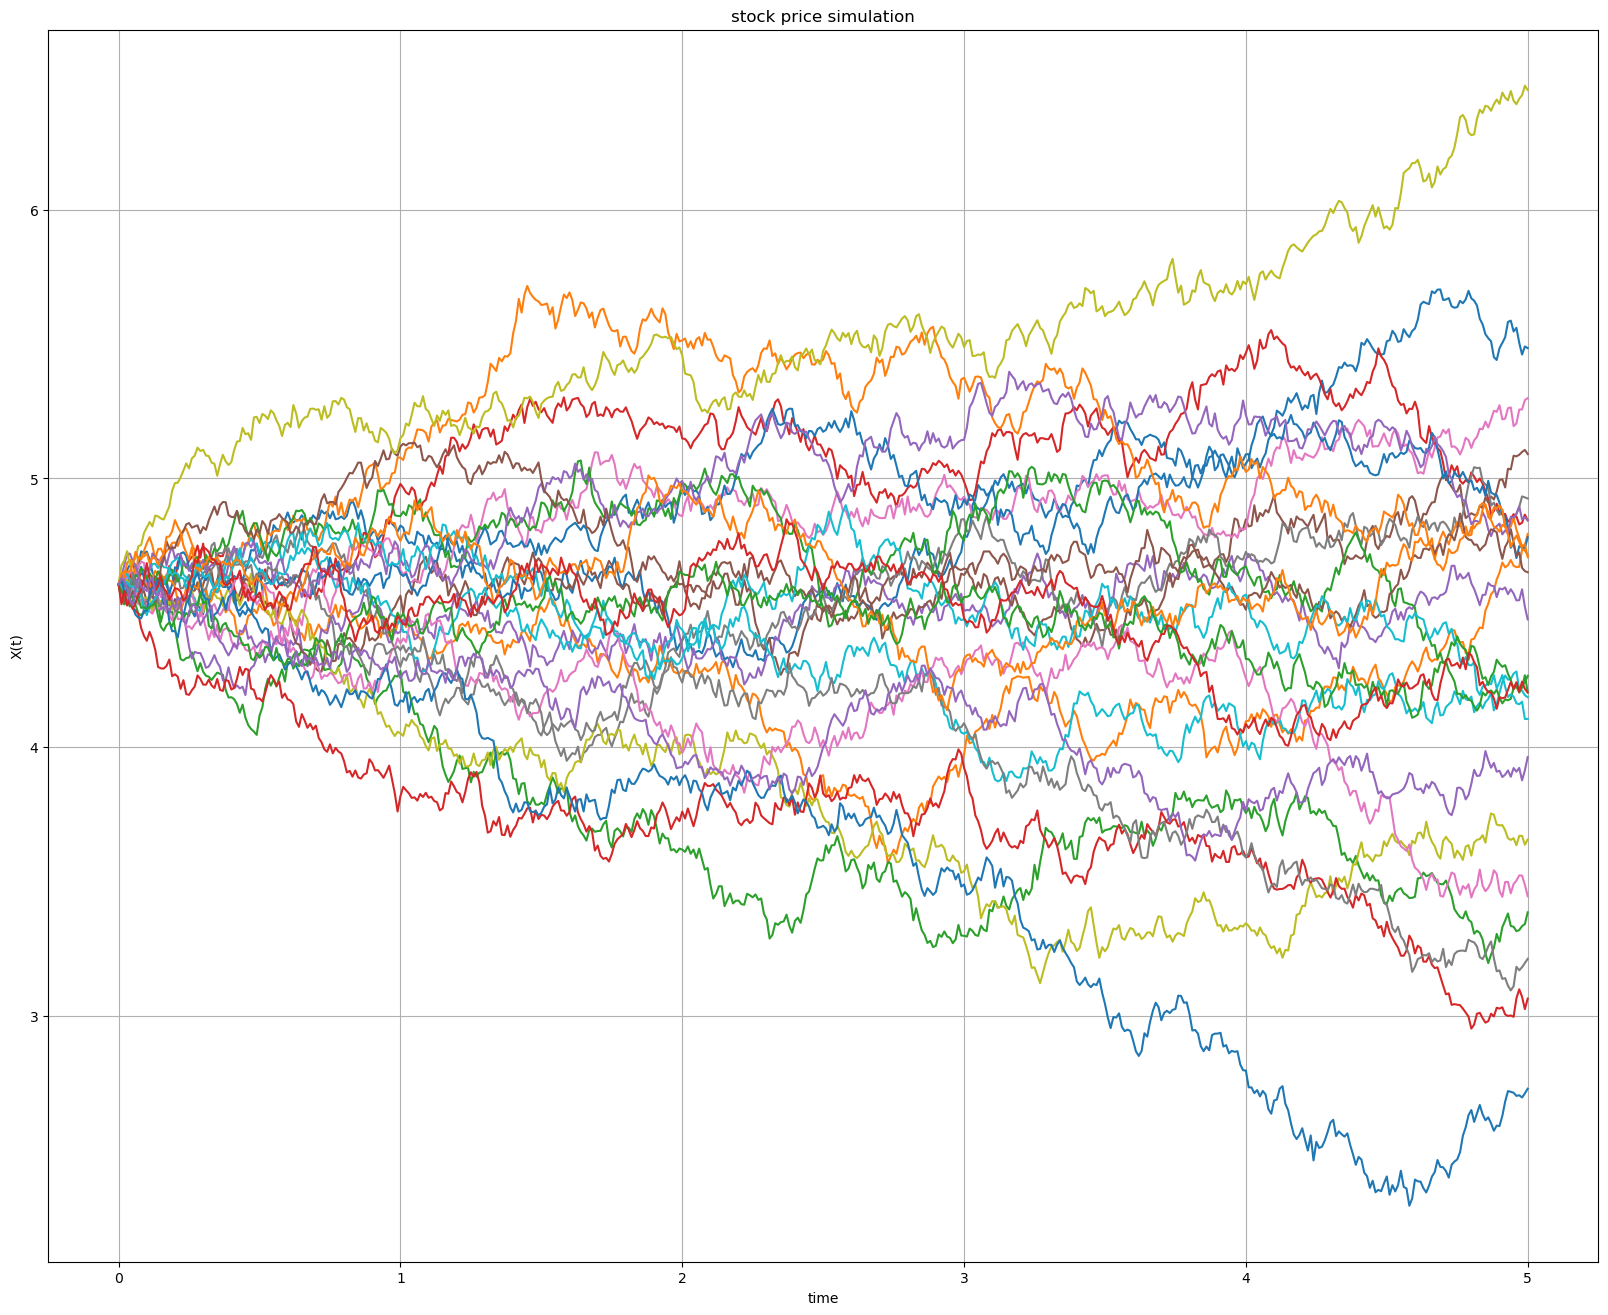

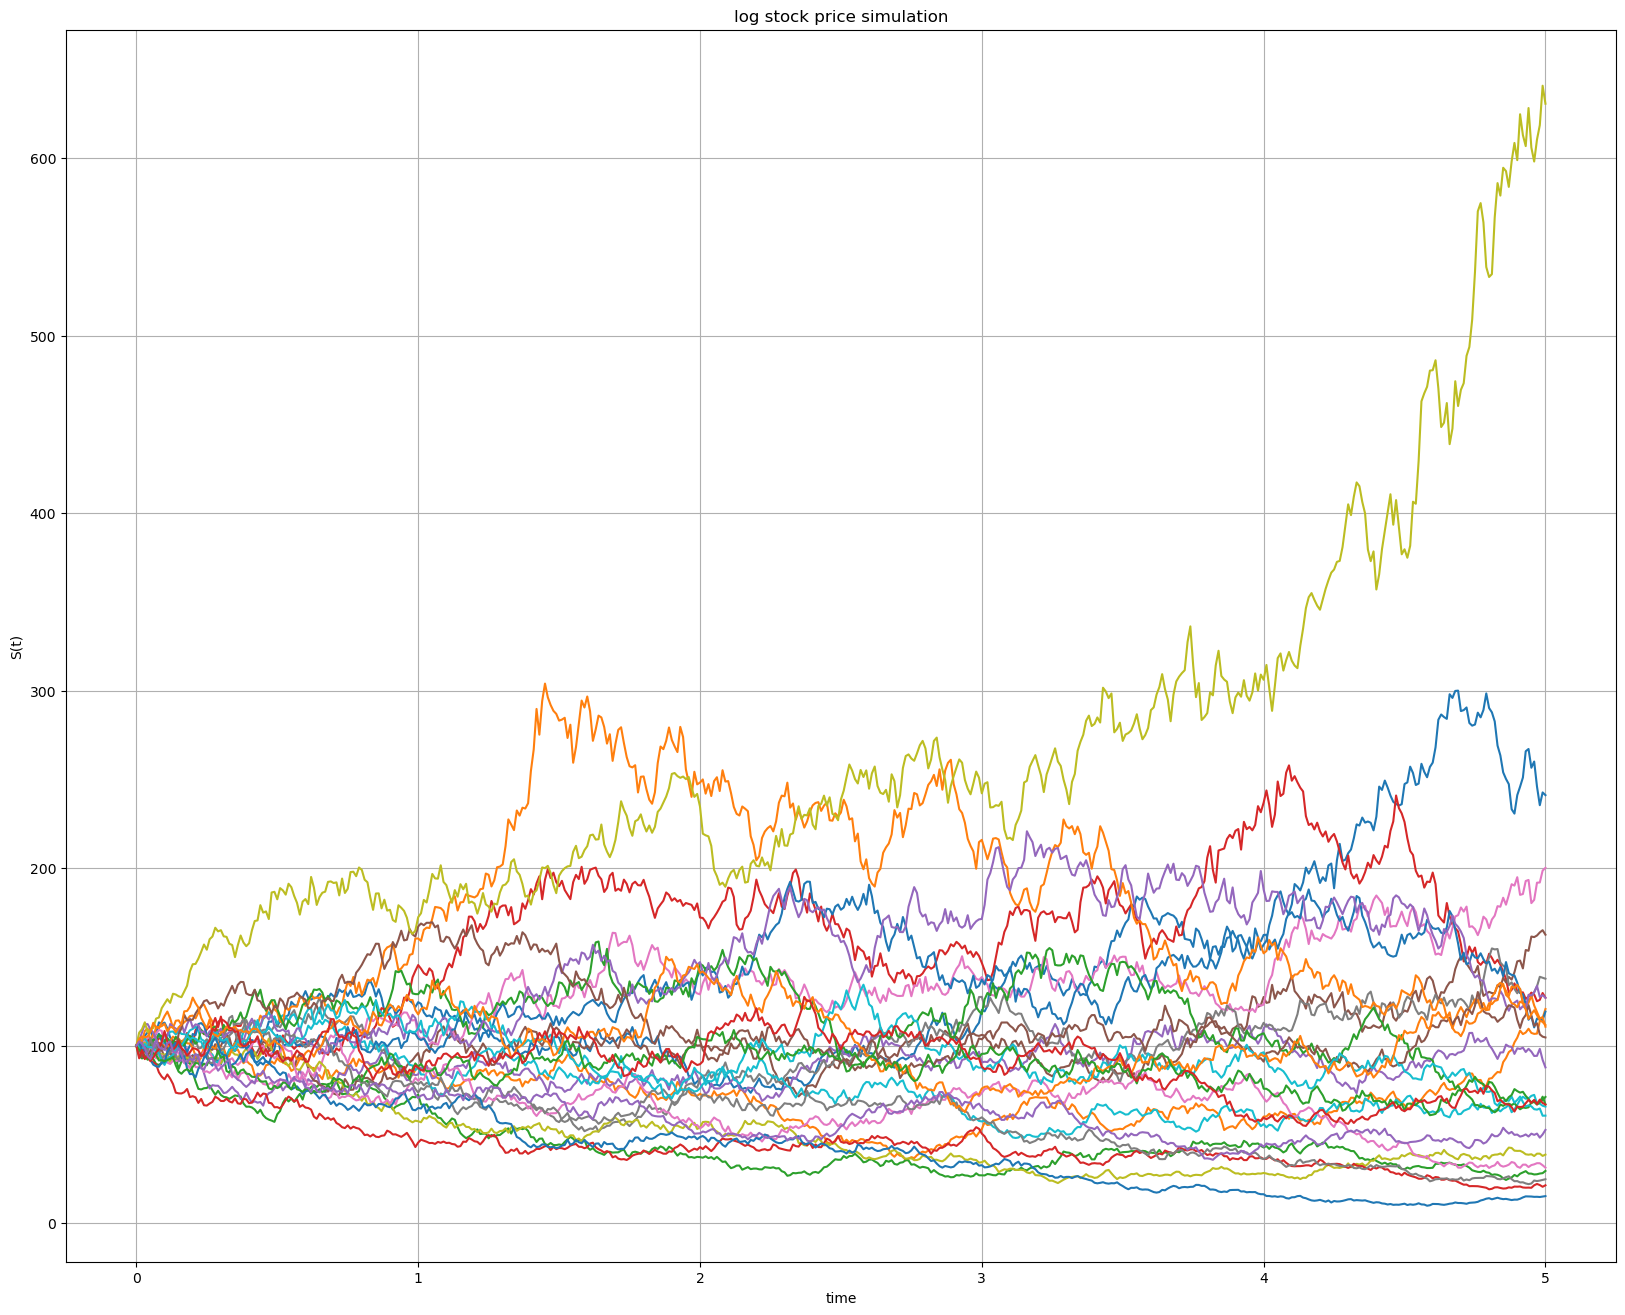

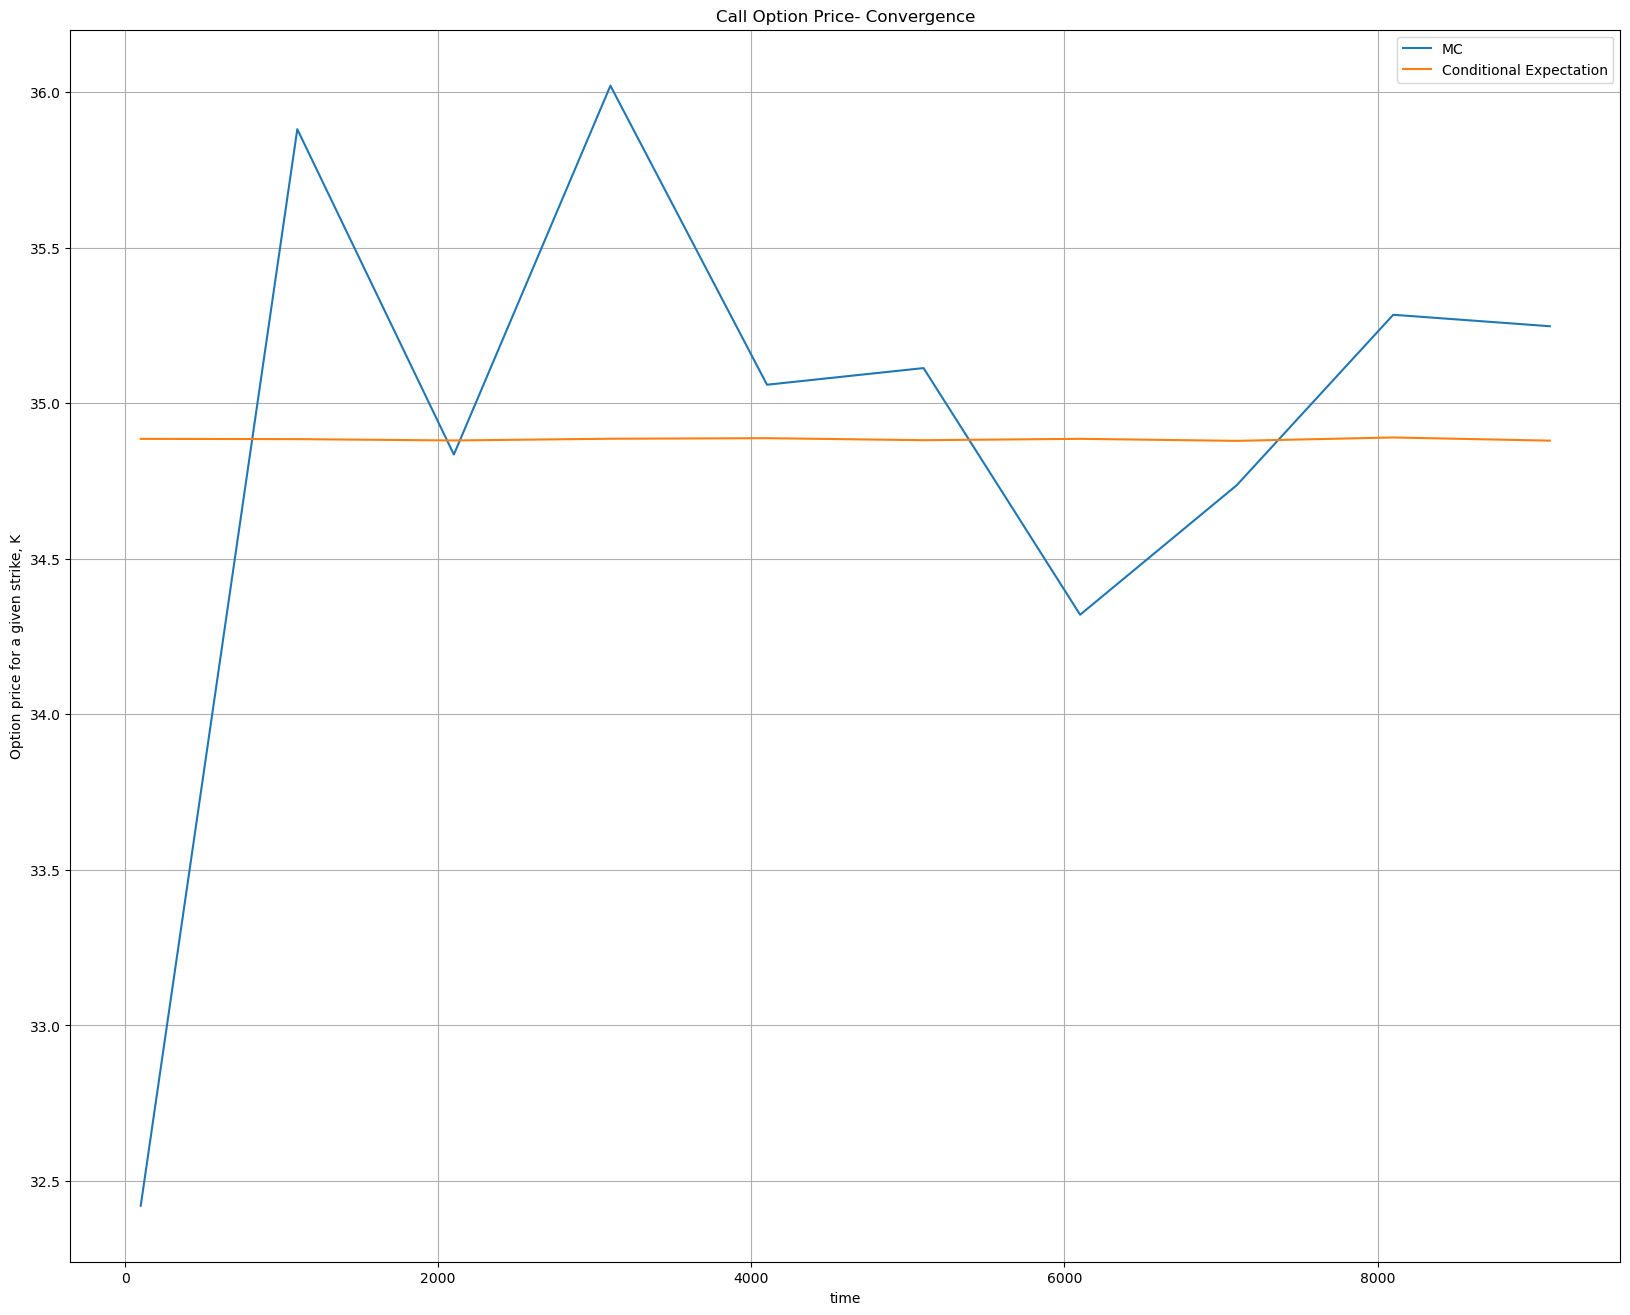

In [6]:
def mainCalculation():
    NoOfPaths = 25
    NoOfSteps = 500
    T = 5
    muJ = 0.3
    sigmaJ = 0.005
    
    S0 =100
    r  =0.00
    Paths=GeneratePaths(NoOfPaths, NoOfSteps, S0, T, muJ, sigmaJ, r)
    timeGrid=Paths["time"]
    X=Paths["X"]
    S=Paths["S"]
    
    # ploting 
    plt.figure(1,figsize=([20,16]))
    plt.plot(timeGrid,X.T)
    plt.xlabel("time")
    plt.ylabel("X(t)")
    plt.title("stock price simulation")
    plt.grid()
    
    plt.figure(2,figsize=([20,16]))
    plt.plot(timeGrid,S.T)
    plt.xlabel("time")
    plt.ylabel("S(t)")
    plt.title("log stock price simulation")
    plt.grid()
    # checking the convergence of following strike
    K=80
    CP =OptionType.CALL
    
    NGrid=range(100,10000,1000)
    NoOfRuns=len(NGrid)
    resultMc=np.zeros([NoOfRuns])
    resultCondExp = np.zeros([NoOfRuns])
    for (i,N) in enumerate(NGrid):
        Paths=GeneratePaths(N, NoOfSteps, S0, T, muJ, sigmaJ, r)
        timeGrid = Paths["time"]
        S = Paths["S"]
        resultMc[i]=EUOptionPriceFromMCPaths(CP, S[:,-1], K, T, r)
        J=Paths["J"]
        resultCondExp[i]=CallOption_CondExpectation(N, T, S0, K, J, r)
    
    plt.figure(3,figsize=([20,16]))
    plt.plot(NGrid,resultMc)  
    plt.plot(NGrid,resultCondExp)
    plt.xlabel("time")
    plt.ylabel('Option price for a given strike, K')
    plt.title('Call Option Price- Convergence')
    plt.legend(['MC','Conditional Expectation'])
    plt.grid()

mainCalculation()

## **Connection to Quant Finance and Industry Practice**

- **Real-World Applications:**  
  - **Derivative Pricing:** Models such as the Black-Scholes and jump-diffusion are fundamental in pricing options, a critical activity in banks, hedge funds, and trading firms.
  - **Risk Management:** Monte Carlo simulations are extensively used to compute risk measures like Value-at-Risk (VaR).

- **Industry Practice:**  
  - **Monte Carlo Methods:** Widely used for scenarios where closed-form solutions are not available.
  - **Variance Reduction Techniques:** Conditional expectation is one such technique that helps in achieving more accurate estimates with fewer simulation paths.

- **Interview Tips for Quants:**  
  - **Understand the Assumptions:** Be clear about the assumptions behind models like Black-Scholes and their limitations.
  - **Discuss Practical Implementations:** Explain how simulation models are used in practice for risk assessment and derivative pricing.
  - **Highlight Efficiency Improvements:** Be prepared to talk about techniques like variance reduction and conditional expectations that improve model performance.

---

## **Nitish Sir Hinglish Explanation**

_Bhai, ye code options ka pricing nikal raha hai using Monte Carlo simulation and Black-Scholes model. Matlab, agar tu option kharidne ka soch raha hai, toh iska expected price kya hoga, ye code batata hai._

1. **GeneratePaths:**  
   _Stock prices ko simulate karta hai using a jump-diffusion process. Isme continuous Brownian motion ke saath-saath sudden jumps bhi aate hain, jo market ke real-life moves ko capture karte hain._

2. **EUOptionPriceFromMCPaths:**  
   _Monte Carlo simulation se, alag-alag scenarios ke hisaab se option ke payoffs calculate karte hain, aur fir unka average discount karke present value nikalte hain._

3. **BS_Call_Put_Option_Price:**  
   _Black-Scholes model industry ka standard hai. Ye closed-form solution provide karta hai jisse theoretical option price nikal sakte hain using \( d_1 \) and \( d_2 \)._

4. **CallOption_CondExpectation:**  
   _Conditional expectation ka use karke, final jump component ke basis par Black-Scholes model lagaya jata hai, jisse variance reduce hota hai aur pricing accurate hoti hai._

5. **mainCalculation:**  
   _Sab functions ko combine karke, overall simulation run karta hai, graphs plot karta hai, aur convergence check karta hai – jo quant finance me bahut important hai._

---

This comprehensive explanation ties together the simulation process, option pricing techniques, and their applications in quant finance. It should serve as a solid foundation for both your academic studies and your upcoming quant interview.
